In [40]:
import pandas as pd
import boto3 
import statsmodels
from datetime import datetime, timedelta
import json
import requests
import pytz
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import plotly.express as px

KEY = "XpqF6xBLLrj6WALk4SS1UlkgphXmHQec"


In [41]:
def convert_timestamp_est(timestamp):
    # Create a UTC datetime object from the timestamp
    utc_datetime = datetime.utcfromtimestamp(timestamp).replace(tzinfo=pytz.utc)
    # Define the EST timezone
    est_timezone = pytz.timezone('America/New_York')
    # Convert the UTC datetime to EST
    est_datetime = utc_datetime.astimezone(est_timezone)
    return est_datetime

def call_polygon_price(symbol, from_stamp, to_stamp,timespan, multiplier):
    trading_hours = [9,10,11,12,13,14,15]
    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/{multiplier}/{timespan}/{from_stamp}/{to_stamp}?adjusted=true&sort=asc&limit=50000&apiKey={KEY}"
    response = execute_polygon_call(url)

    response_data = json.loads(response.text)
    results = response_data['results']
    results_df = pd.DataFrame(results)
    results_df['t'] = results_df['t'].apply(lambda x: int(x/1000))
    results_df['date'] = results_df['t'].apply(lambda x: convert_timestamp_est(x))
    results_df['hour'] = results_df['date'].apply(lambda x: x.hour)
    results_df['day'] = results_df['date'].apply(lambda x: x.day)
    results_df['minute'] = results_df['date'].apply(lambda x: x.minute)
    results_df['range_vol'] = (results_df['o'] - results_df['c'])/results_df['o']
    results_df['return_vol'] = results_df['c'].pct_change()
    results_df = results_df.loc[results_df['hour'].isin(trading_hours)]
    results_df = results_df.loc[~((results_df['hour'] == 9) & (results_df['minute'] < 30))]

    return results_df

def setup_session_retries(
    retries: int = 3,
    backoff_factor: float = 0.05,
    status_forcelist: tuple = (500, 502, 504),
):
    """
    Sets up a requests Session with retries.
    
    Parameters:
    - retries: Number of retries before giving up. Default is 3.
    - backoff_factor: A factor to use for exponential backoff. Default is 0.3.
    - status_forcelist: A tuple of HTTP status codes that should trigger a retry. Default is (500, 502, 504).

    Returns:
    - A requests Session object with retry configuration.
    """
    retry_strategy = CustomRetry(
        total=retries,
        backoff_factor=backoff_factor,
        status_forcelist=status_forcelist,
        allowed_methods=frozenset(["GET", "POST", "PUT", "DELETE", "HEAD", "OPTIONS"]),
        raise_on_status=False
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session = requests.Session()
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    
    return session

def execute_polygon_call(url):
    session = setup_session_retries()
    response = session.request("GET", url, headers={}, data={})
    return response 

class CustomRetry(Retry):
    def is_retry(self, method, status_code, has_retry_after=False):
        """ Return True if we should retry the request, otherwise False. """
        if status_code != 200:
            return True
        return super().is_retry(method, status_code, has_retry_after)

In [42]:
symbols = ['AAPL','QQQ','AMZN','SPY','NVDA','META','NFLX']
aggregate_dfs = {}
for symbol in symbols:
    from_stamp = "2024-04-01"
    to_stamp = "2024-08-01"
    timespan = "minute"
    multiplier = 30
    df = call_polygon_price(symbol, from_stamp, to_stamp,timespan, multiplier)
    aggregate_dfs[symbol] = df



### Visualize Volatility and Volume

In [43]:
df = aggregate_dfs['AAPL']
# Create the line chart
fig = px.line(df, x='date', y='range_vol', title='Range Volatility')

# Update layout
fig.update_layout(
    xaxis_title='X Axis',
    yaxis_title='Y Axis'
)

fig.show()

In [44]:
df = aggregate_dfs['AAPL']
# Create the line chart
fig = px.line(df, x='date', y='v', title='Volume')

# Update layout
fig.update_layout(
    xaxis_title='X Axis',
    yaxis_title='Y Axis'
)

fig.show()

In [45]:
df = aggregate_dfs['SPY']
# Create the line chart
fig = px.line(df, x='date', y='range_vol', title='Range Volatility')

# Update layout
fig.update_layout(
    xaxis_title='X Axis',
    yaxis_title='Y Axis'
)

fig.show()

In [46]:
df = aggregate_dfs['SPY']
# Create the line chart
fig = px.line(df, x='date', y='v', title='Volume')

# Update layout
fig.update_layout(
    xaxis_title='X Axis',
    yaxis_title='Y Axis'
)

fig.show()

## AutoCorr

In [47]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks

# Assuming your DataFrame is named 'df' and has a datetime index
# If not, you'll need to set the index: df.set_index('datetime_column', inplace=True)
df = aggregate_dfs['SPY'].copy()
df.set_index('date', inplace=True)

# Calculate the autocorrelation
lag_max = 14 * 7  # 7 days worth of lags
autocorr = acf(df['v'], nlags=lag_max)

# Create a pandas Series with the autocorrelation values
autocorr_series = pd.Series(autocorr)

# Create the Plotly figure
fig = go.Figure()

# Add the autocorrelation line
fig.add_trace(go.Scatter(x=autocorr_series.index, y=autocorr_series.values,
                         mode='lines', name='Autocorrelation'))

# Add vertical lines for daily periods
for i in range(1, 8):
    fig.add_shape(type="line", x0=14*i, y0=0, x1=14*i, y1=1,
                  line=dict(color="red", width=1, dash="dash"))

# Update layout
fig.update_layout(
    title='Autocorrelation Plot',
    xaxis_title='Lag',
    yaxis_title='Autocorrelation',
    showlegend=True
)

# Show the plot
# fig.show()

# Find the peaks in autocorrelation
peaks, _ = find_peaks(autocorr, height=0.1, distance=7)  # Adjust height and distance as needed
print("Peaks found at lags:", peaks)

# Calculate the average distance between peaks
if len(peaks) > 1:
    avg_peak_distance = np.mean(np.diff(peaks))
    print(f"Average distance between peaks: {avg_peak_distance:.2f}")
    print(f"Detected periodicity: {avg_peak_distance / 14:.2f} days")
else:
    print("Not enough peaks detected to determine periodicity.")

# Optional: Add markers for the detected peaks
fig.add_trace(go.Scatter(x=peaks, y=autocorr[peaks],
                         mode='markers', name='Peaks',
                         marker=dict(size=8, color='green', symbol='star')))

# Update the layout to accommodate the new trace
fig.update_layout(showlegend=True)

# Show the updated plot
fig.show()

Peaks found at lags: [13 26 39 52 65 78 91]
Average distance between peaks: 13.00
Detected periodicity: 0.93 days


In [48]:
# Assuming your DataFrame is named 'df' and has a datetime index
# If not, you'll need to set the index: df.set_index('datetime_column', inplace=True)
df = aggregate_dfs['QQQ'].copy()
df.set_index('date', inplace=True)

# Calculate the autocorrelation
lag_max = 14 * 7  # 7 days worth of lags
autocorr = acf(df['v'], nlags=lag_max)

# Create a pandas Series with the autocorrelation values
autocorr_series = pd.Series(autocorr)

# Create the Plotly figure
fig = go.Figure()

# Add the autocorrelation line
fig.add_trace(go.Scatter(x=autocorr_series.index, y=autocorr_series.values,
                         mode='lines', name='Autocorrelation'))

# Add vertical lines for daily periods
for i in range(1, 8):
    fig.add_shape(type="line", x0=14*i, y0=0, x1=14*i, y1=1,
                  line=dict(color="red", width=1, dash="dash"))

# Update layout
fig.update_layout(
    title='Autocorrelation Plot',
    xaxis_title='Lag',
    yaxis_title='Autocorrelation',
    showlegend=True
)

# Show the plot
# fig.show()

# Find the peaks in autocorrelation
peaks, _ = find_peaks(autocorr, height=0.1, distance=7)  # Adjust height and distance as needed
print("Peaks found at lags:", peaks)

# Calculate the average distance between peaks
if len(peaks) > 1:
    avg_peak_distance = np.mean(np.diff(peaks))
    print(f"Average distance between peaks: {avg_peak_distance:.2f}")
    print(f"Detected periodicity: {avg_peak_distance / 14:.2f} days")
else:
    print("Not enough peaks detected to determine periodicity.")

# Optional: Add markers for the detected peaks
fig.add_trace(go.Scatter(x=peaks, y=autocorr[peaks],
                         mode='markers', name='Peaks',
                         marker=dict(size=8, color='green', symbol='star')))

# Update the layout to accommodate the new trace
fig.update_layout(showlegend=True)

# Show the updated plot
fig.show()

Peaks found at lags: [13 26 39 52 65 78 91]
Average distance between peaks: 13.00
Detected periodicity: 0.93 days


In [49]:
# Assuming your DataFrame is named 'df' and has a datetime index
# If not, you'll need to set the index: df.set_index('datetime_column', inplace=True)
df = aggregate_dfs['SPY'].copy()
df.set_index('date', inplace=True)

# Calculate the autocorrelation
lag_max = 14 * 7  # 7 days worth of lags
autocorr = acf(df['v'], nlags=lag_max)

# Create a pandas Series with the autocorrelation values
autocorr_series = pd.Series(autocorr)

# Create the Plotly figure
fig = go.Figure()

# Add the autocorrelation line
fig.add_trace(go.Scatter(x=autocorr_series.index, y=autocorr_series.values,
                         mode='lines', name='Autocorrelation'))

# Add vertical lines for daily periods
for i in range(1, 8):
    fig.add_shape(type="line", x0=14*i, y0=0, x1=14*i, y1=1,
                  line=dict(color="red", width=1, dash="dash"))

# Update layout
fig.update_layout(
    title='Autocorrelation Plot',
    xaxis_title='Lag',
    yaxis_title='Autocorrelation',
    showlegend=True
)

# Show the plot
# fig.show()

# Find the peaks in autocorrelation
peaks, _ = find_peaks(autocorr, height=0.1, distance=13)  # Adjust height and distance as needed
print("Peaks found at lags:", peaks)

# Calculate the average distance between peaks
if len(peaks) > 1:
    avg_peak_distance = np.mean(np.diff(peaks))
    print(f"Average distance between peaks: {avg_peak_distance:.2f}")
    print(f"Detected periodicity: {avg_peak_distance / 13:.2f} days")
else:
    print("Not enough peaks detected to determine periodicity.")

# Optional: Add markers for the detected peaks
fig.add_trace(go.Scatter(x=peaks, y=autocorr[peaks],
                         mode='markers', name='Peaks',
                         marker=dict(size=8, color='green', symbol='star')))

# Update the layout to accommodate the new trace
fig.update_layout(showlegend=True)

# Show the updated plot
fig.show()

Peaks found at lags: [13 26 39 52 65 78 91]
Average distance between peaks: 13.00
Detected periodicity: 1.00 days


### Decomposition of Volume Signal

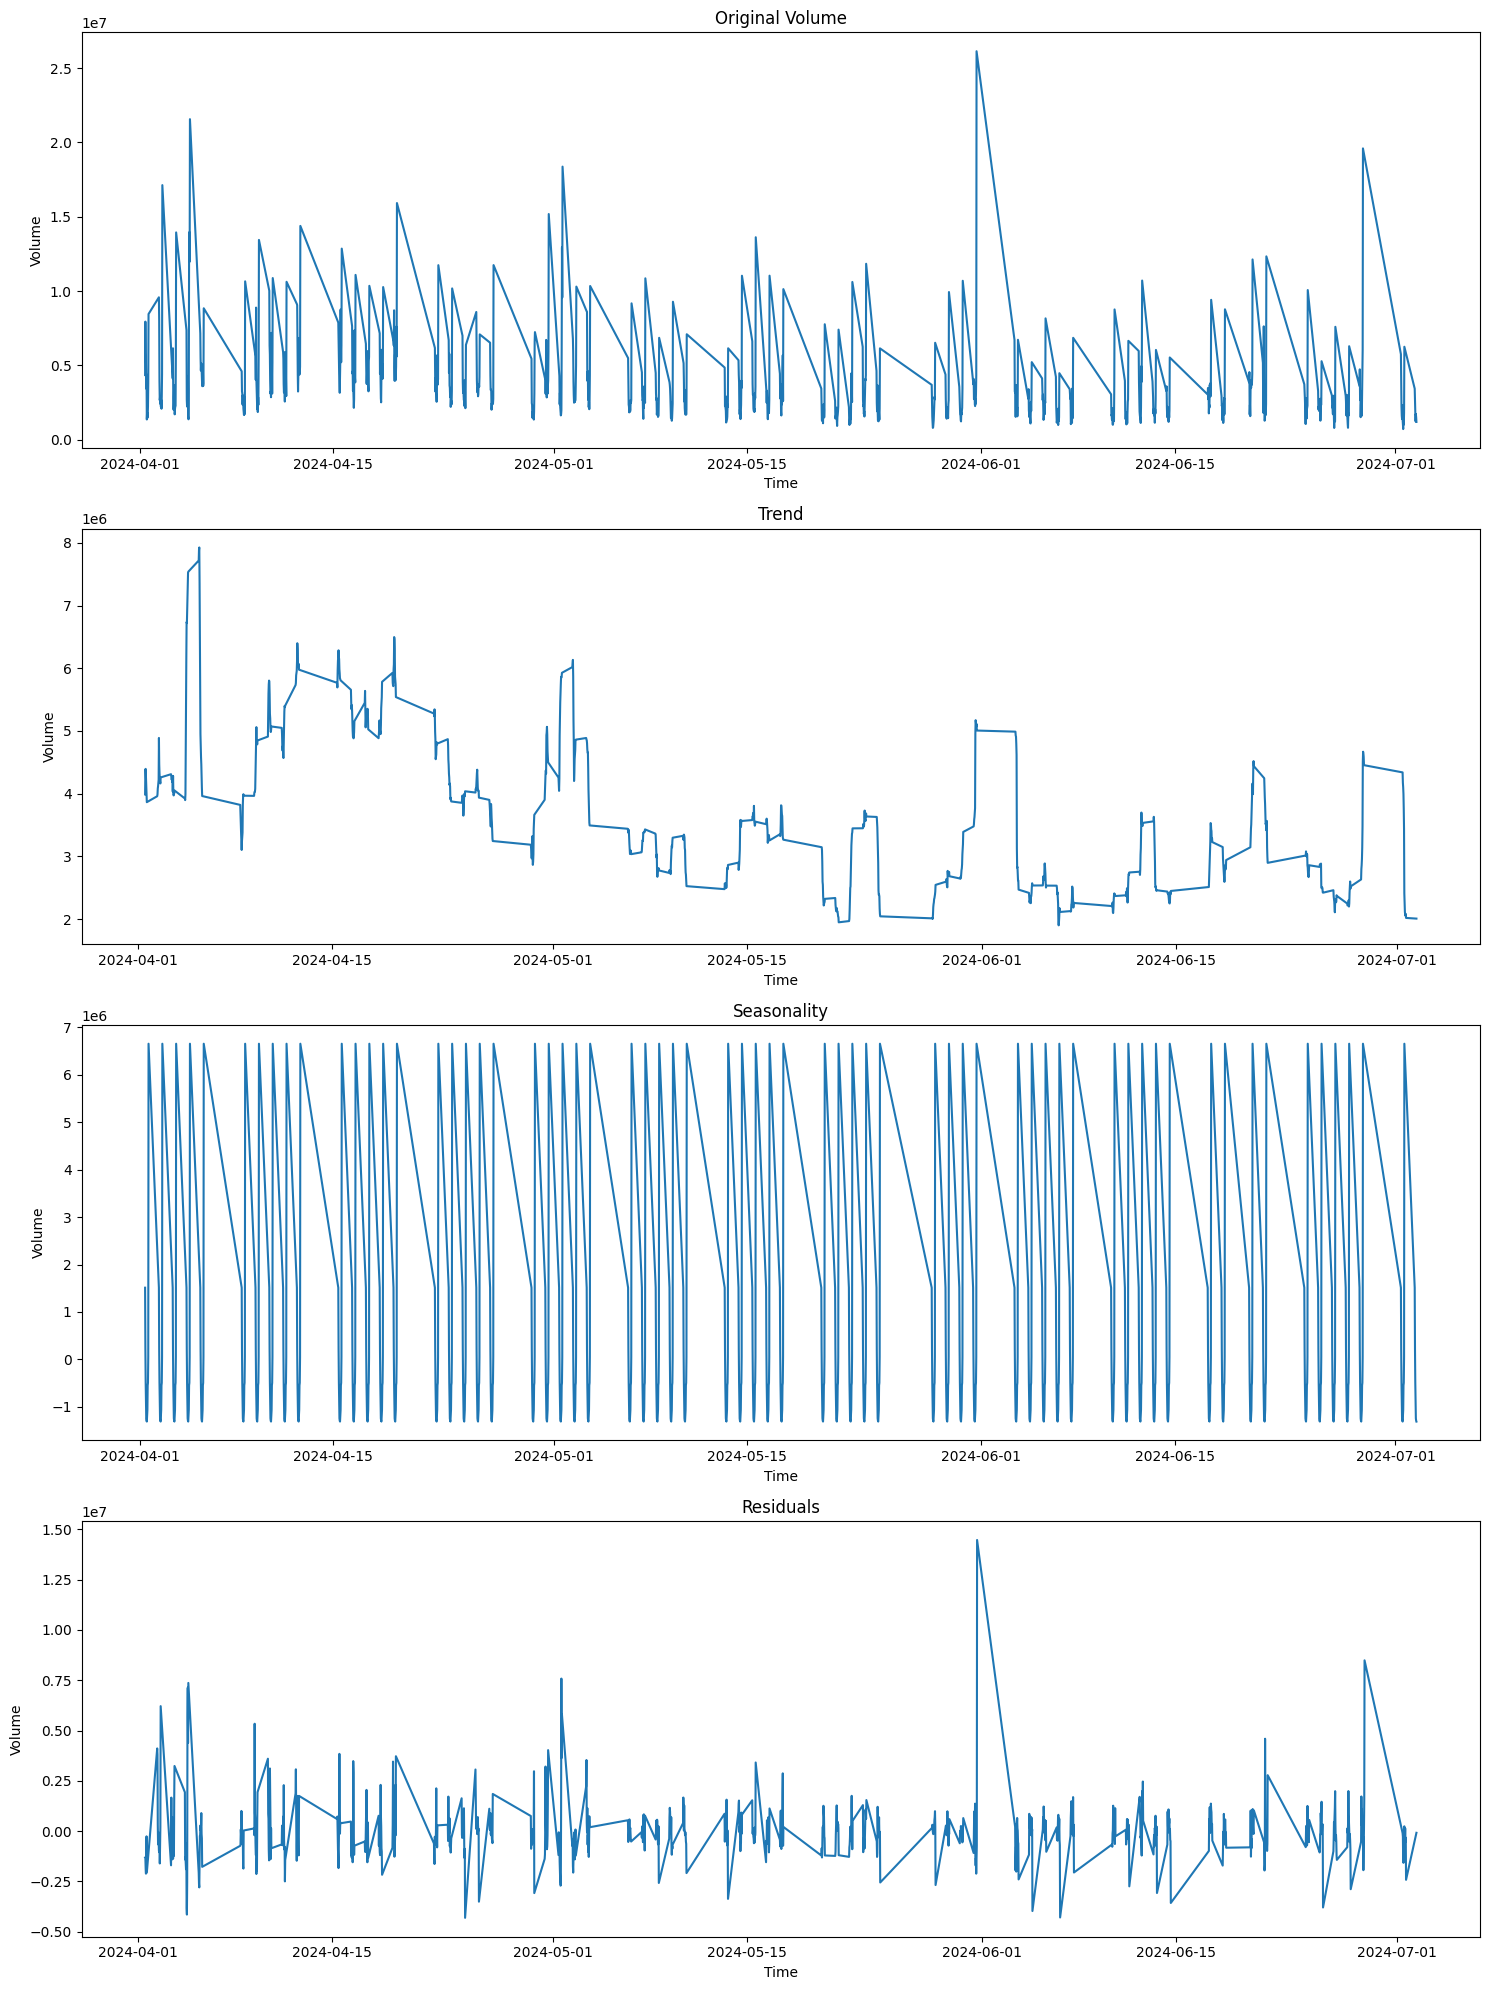

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta

# Perform seasonal decomposition
def decompose_volume(df):
    decomposition = seasonal_decompose(df['v'], model='additive', period=13)  # 288 = 24 hours * 12 (5-minute intervals)
    
    df['trend'] = decomposition.trend
    df['seasonal'] = decomposition.seasonal
    df['residual'] = decomposition.resid
    
    return df

# Plot the decomposition
def plot_decomposition(df):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 20))
    
    ax1.plot(df['date'], df['v'])
    ax1.set_title('Original Volume')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Volume')
    
    ax2.plot(df['date'], df['trend'])
    ax2.set_title('Trend')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Volume')
    
    ax3.plot(df['date'], df['seasonal'])
    ax3.set_title('Seasonality')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Volume')
    
    ax4.plot(df['date'], df['residual'])
    ax4.set_title('Residuals')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('Volume')
    
    plt.tight_layout()
    plt.show()

    
# Perform decomposition
df = aggregate_dfs['SPY'].copy()
df = decompose_volume(df)

# Plot results
plot_decomposition(df)
    



In [51]:
df['trend_pct'] = df['trend'].pct_change()
df.groupby('hour')['trend_pct'].describe()

/var/folders/tq/_9q_lv1s2bndbr3tzzn08x4r0000gn/T/ipykernel_55919/2688749579.py:1: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
9,64.0,-0.000001,0.027126,-0.054193,-0.018364,-0.000549,0.013360,0.069504
10,128.0,-0.000063,0.026967,-0.058550,-0.018572,-0.001705,0.015696,0.073276
11,128.0,0.002127,0.045962,-0.117994,-0.023509,0.002664,0.019045,0.192700
12,128.0,0.000331,0.080915,-0.323311,-0.034507,-0.001560,0.038806,0.315064
13,128.0,-0.000019,0.036772,-0.097450,-0.026567,-0.001445,0.023324,0.112675
14,128.0,-0.000240,0.035490,-0.118389,-0.018449,-0.001588,0.017372,0.132691
15,128.0,-0.001049,0.022593,-0.056720,-0.014136,-0.001572,0.012765,0.061012


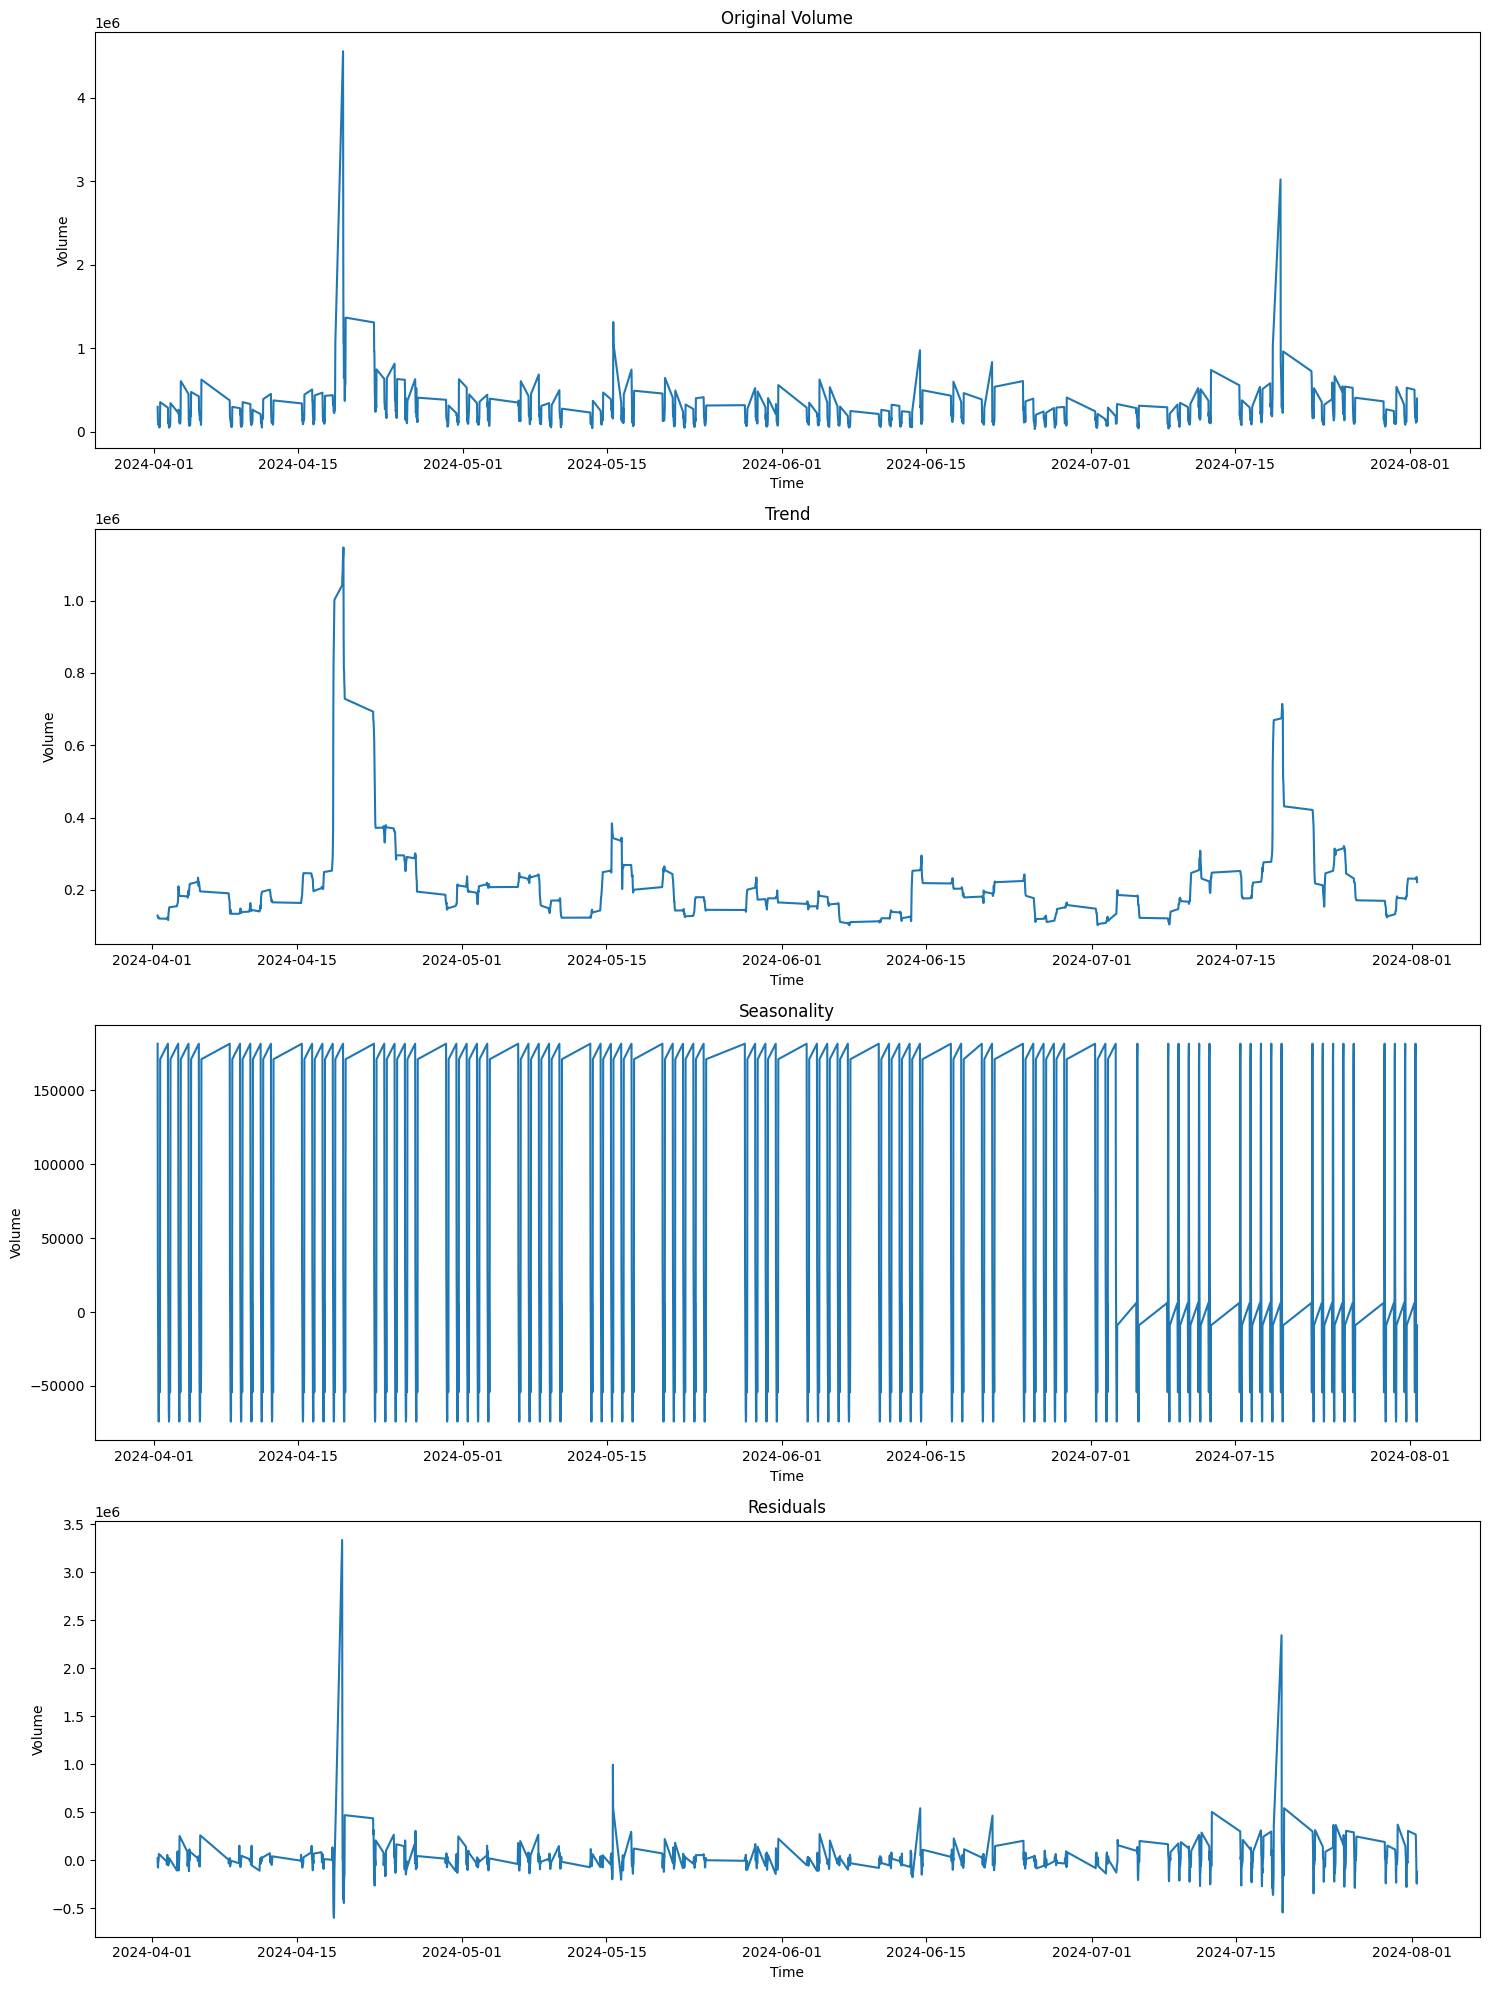

In [52]:
# Perform decomposition
df = aggregate_dfs['NFLX'].copy()
df = decompose_volume(df)

# Plot results
plot_decomposition(df)
    



In [53]:
df['trend_pct'] = df['trend'].pct_change()
df.groupby('hour')['trend_pct'].describe()

/var/folders/tq/_9q_lv1s2bndbr3tzzn08x4r0000gn/T/ipykernel_55919/2688749579.py:1: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
9,85.0,0.002679,0.030031,-0.063007,-0.012037,0.001630,0.019460,0.155833
10,170.0,0.001737,0.029573,-0.098627,-0.012711,0.002530,0.015571,0.144552
11,170.0,0.001297,0.026258,-0.070116,-0.015612,0.002017,0.017504,0.080775
12,170.0,-0.000493,0.064259,-0.264874,-0.032104,-0.001912,0.022273,0.364031
13,171.0,0.009169,0.109811,-0.254297,-0.042114,-0.006443,0.039911,0.856442
14,170.0,-0.000182,0.041488,-0.104728,-0.028000,-0.000390,0.027267,0.129343
15,170.0,-0.000512,0.028489,-0.124445,-0.019478,0.000000,0.018717,0.086479


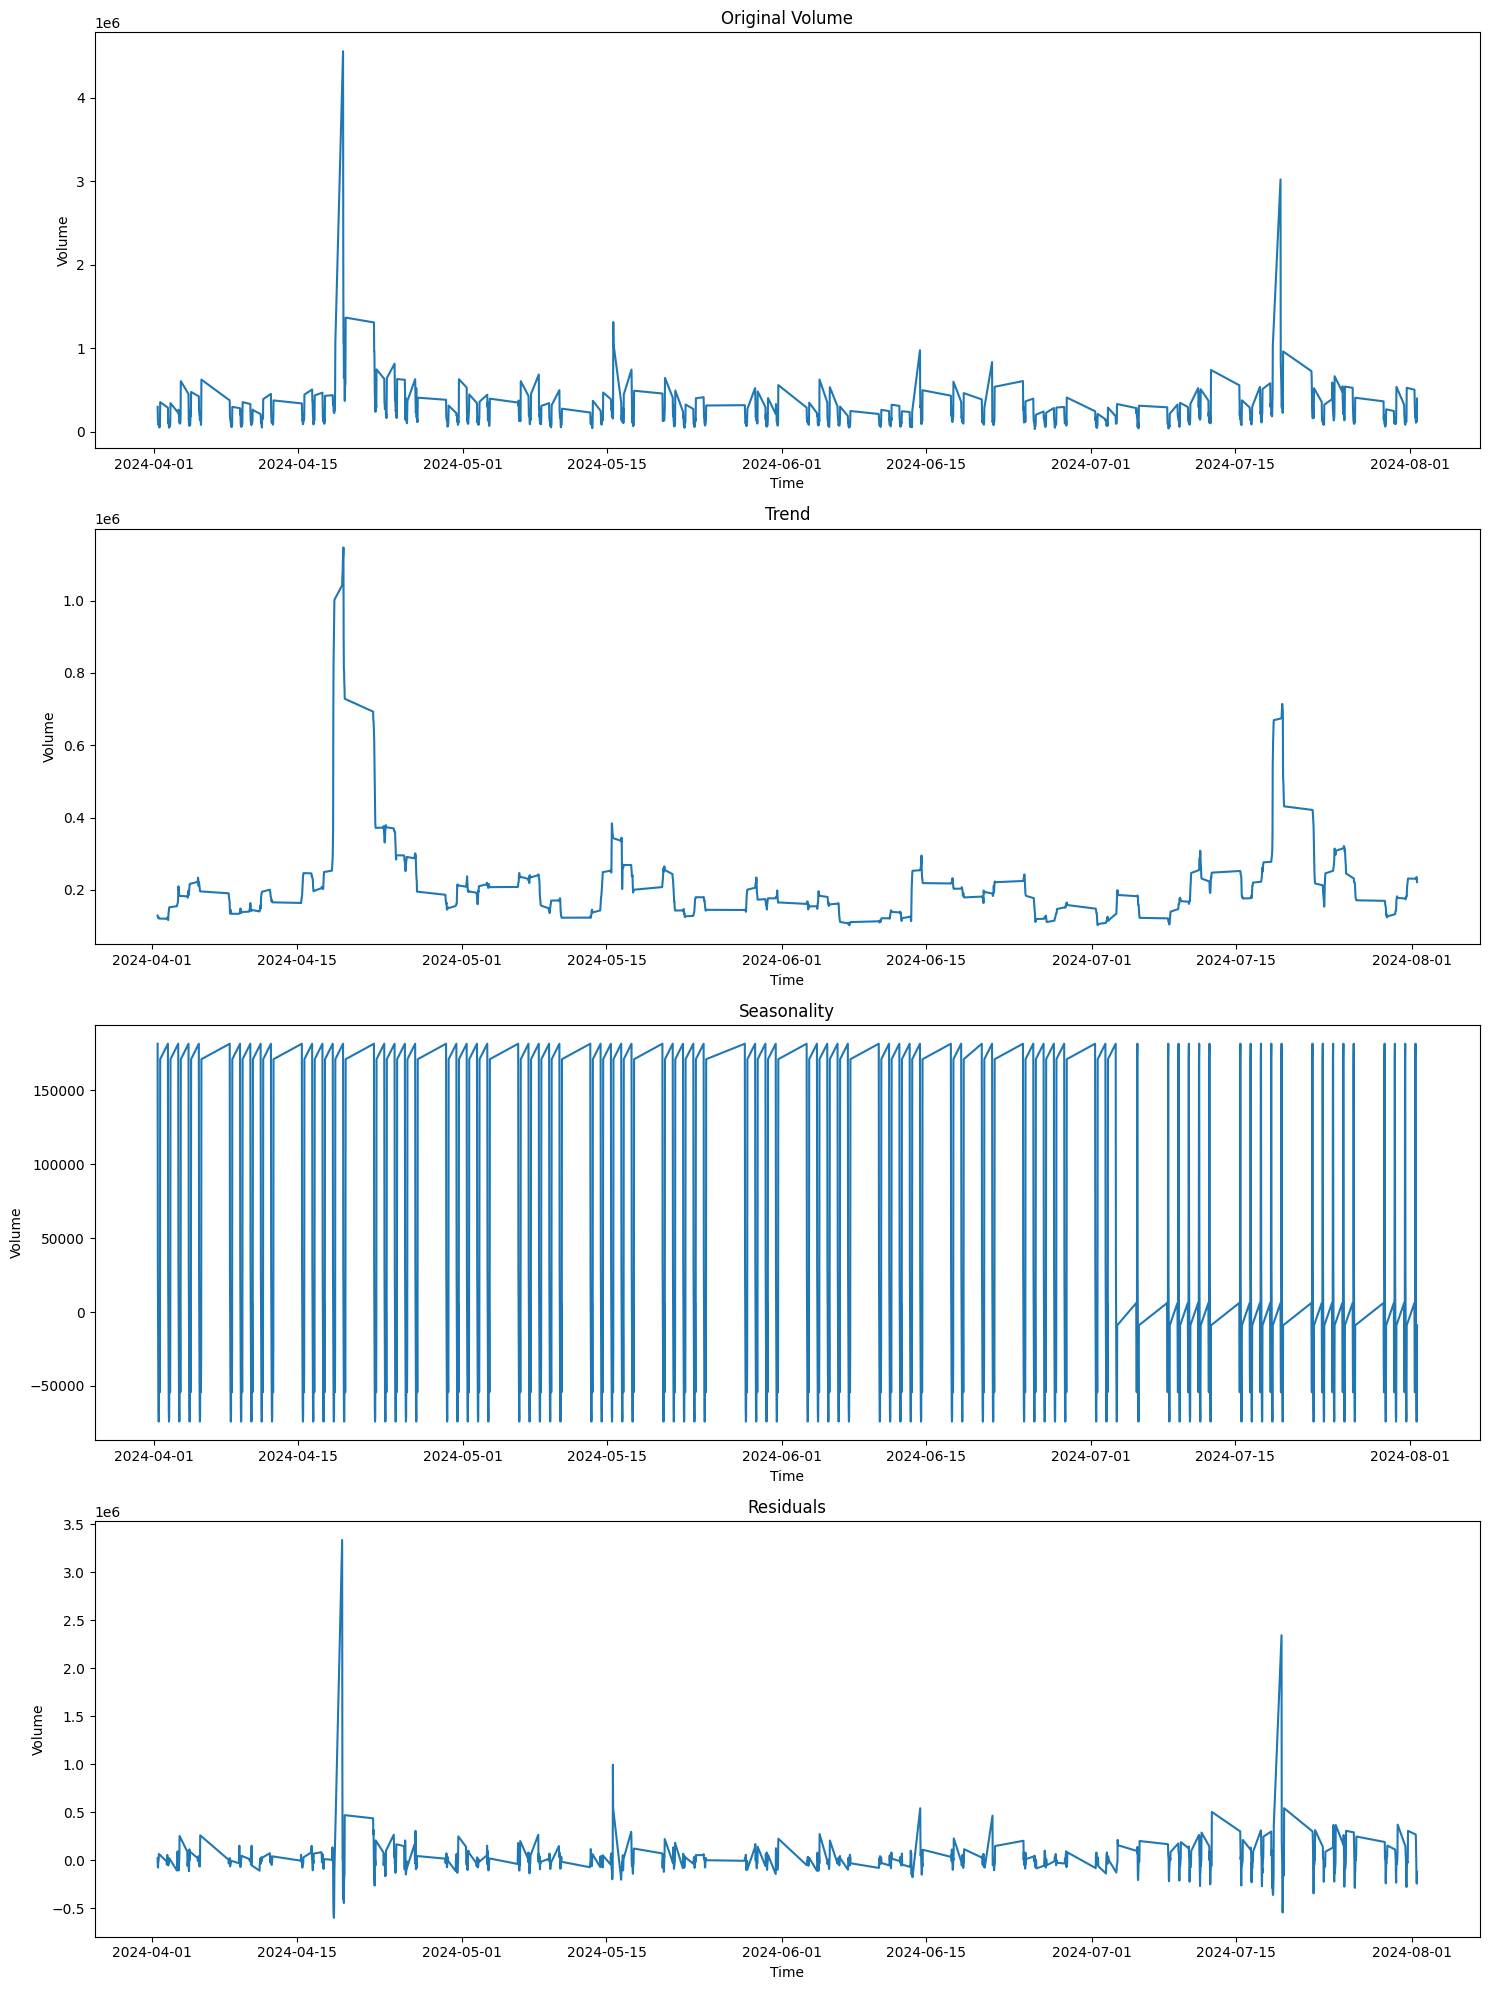

In [54]:
# Perform decomposition
df = aggregate_dfs['NFLX'].copy()
df = decompose_volume(df)

# Plot results
plot_decomposition(df)

In [55]:
df['trend_pct'] = df['trend'].pct_change()
df.groupby('hour')['trend_pct'].describe()

/var/folders/tq/_9q_lv1s2bndbr3tzzn08x4r0000gn/T/ipykernel_55919/2688749579.py:1: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
9,85.0,0.002679,0.030031,-0.063007,-0.012037,0.001630,0.019460,0.155833
10,170.0,0.001737,0.029573,-0.098627,-0.012711,0.002530,0.015571,0.144552
11,170.0,0.001297,0.026258,-0.070116,-0.015612,0.002017,0.017504,0.080775
12,170.0,-0.000493,0.064259,-0.264874,-0.032104,-0.001912,0.022273,0.364031
13,171.0,0.009169,0.109811,-0.254297,-0.042114,-0.006443,0.039911,0.856442
14,170.0,-0.000182,0.041488,-0.104728,-0.028000,-0.000390,0.027267,0.129343
15,170.0,-0.000512,0.028489,-0.124445,-0.019478,0.000000,0.018717,0.086479


### TDA: Sliding Window and Persistent Homology 

In [57]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from ripser import ripser
from persim import plot_diagrams
import matplotlib.pyplot as plt

class TimeSeriesAnomalyDetector:
    def __init__(self, window_size, stride, expected_period, threshold):
        self.window_size = window_size
        self.stride = stride
        self.expected_period = expected_period
        self.threshold = threshold

    def sliding_window_embedding(self, data):
        return np.array([data[i:i+self.window_size] for i in range(0, len(data) - self.window_size + 1, self.stride)])

    def compute_persistence(self, window):
        scaler = StandardScaler()
        normalized_window = scaler.fit_transform(window.reshape(-1, 1)).flatten()
        diagrams = ripser(normalized_window.reshape(-1, 1))['dgms']
        return diagrams[1]  # Return 1-dimensional persistence diagram

    def measure_periodicity(self, persistence_diagram):
        if len(persistence_diagram) == 0:
            return 0
        
        # Calculate the maximum persistence
        max_persistence = np.max(persistence_diagram[:, 1] - persistence_diagram[:, 0])
        return max_persistence

    def detect_anomalies(self, time_series):
        embedded_data = self.sliding_window_embedding(time_series)
        periodicities = []

        for window in embedded_data:
            persistence_diagram = self.compute_persistence(window)
            periodicity = self.measure_periodicity(persistence_diagram)
            periodicities.append(periodicity)

        # Detect anomalies
        anomalies = []
        for i, periodicity in enumerate(periodicities):
            if abs(periodicity - self.expected_period) > self.threshold:
                anomalies.append(i * self.stride)

        return anomalies, periodicities

    def plot_results(self, time_series, periodicities, anomalies):
        plt.figure(figsize=(12, 6))
        plt.plot(time_series, label='Time Series')
        plt.plot(np.arange(len(periodicities)) * self.stride, periodicities, label='Periodicity')
        plt.scatter(anomalies, [time_series[i] for i in anomalies], color='red', label='Anomalies')
        plt.legend()
        plt.title('Time Series Anomaly Detection')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.show()

Detected anomalies at indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215

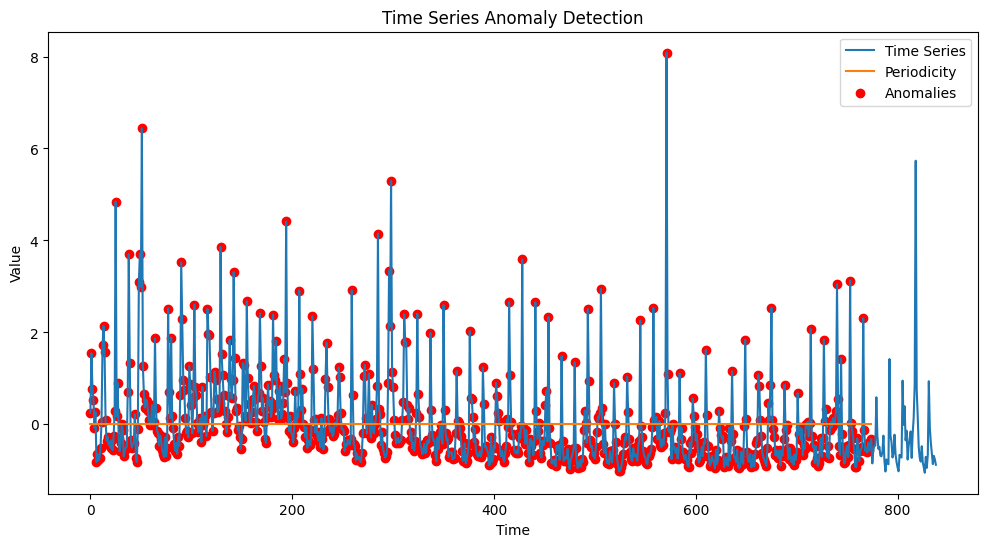

In [60]:
df = aggregate_dfs['SPY'].copy()
normal_data = df['v'].values
## use the standard scaler to normalize the data
scaler = StandardScaler()
normal_data = scaler.fit_transform(normal_data.reshape(-1, 1)).flatten()
detector = TimeSeriesAnomalyDetector(window_size=65, stride=1, expected_period=13, threshold=0.5)
detected_anomalies, periodicities = detector.detect_anomalies(normal_data)

print(f"Detected anomalies at indices: {detected_anomalies}")
detector.plot_results(normal_data, periodicities, detected_anomalies)